# Análise Gráfica das Palavras Hidroxicloroquina e Cloroquina
#### (Daniel)

## Implementando Funções

In [80]:
import nltk
import re
import pandas as pd
from IPython.display import clear_output
from collections import defaultdict
from string import punctuation
import numpy as np
#stopwords em portugues
from nltk.corpus import stopwords
stopwords = set(stopwords.words('portuguese') + list(punctuation) + ['“','”'])

#funçao pra limpeza de texto
from nltk.tokenize import TweetTokenizer
tweet_tokenizer = TweetTokenizer(strip_handles=True, reduce_len=True, preserve_case=False)

In [81]:
#funçao pra leitura de dados e criaçao de dataframe
def json_to_dataframe(nome_json, colunas, chunk):
    dados = pd.read_json(nome_json, convert_dates = False, lines = True, chunksize = chunk)    
    
    for df_tweets_retweets in dados:
        yield df_tweets_retweets[colunas]

In [82]:
#funçao pra leitura de dados e criaçao de dataframe
def json_to_dataframe_retweets(nome_json, colunas, chunk):
    dados = pd.read_json(nome_json, convert_dates = False, lines = True, chunksize = chunk)    
    
    for df_tweets_retweets in dados:
        yield df_tweets_retweets.dropna(subset=['retweeted_status'])[colunas]

In [83]:
#funçao pra limpar texto e retirar stopwords
def tokenizar_texto(texto_tweet):
    texto_tokenizado = tweet_tokenizer.tokenize(texto_tweet)

    if texto_tokenizado[0] == "rt" and texto_tokenizado[1] == ":":
        del texto_tokenizado[0]
    
    palavras_sem_stopwords = [palavra for palavra in texto_tokenizado if palavra not in stopwords] 
    return palavras_sem_stopwords

In [84]:
#funçao pra criar dicionario com a data e quantidade das palavras chaves
def contagem_pchaves_data(pchaves_lista, gerador,destino):
    
    dict_datas_pchaves = defaultdict(dict)            
    
    for dataframe in gerador:        
        for linha in dataframe.values:            
            texto_tweet = list(tokenizar_texto(linha[0]))

            for palavra in texto_tweet:                
                if palavra in pchaves_lista:
                    data = linha[1]['$date'][:10]
                    if data not in dict_datas_pchaves or palavra not in dict_datas_pchaves[data]:
                        dict_datas_pchaves[data][palavra] = 0
                    dict_datas_pchaves[data][palavra] += 1 
            clear_output()
            
    escrever_arq_csv(dict_datas_pchaves,destino)

In [85]:
#funcao que conta a quantidade e proporção de retweets nos tweets
def prop_retweets(arquivo):
    retweets=0
    tweets=0
    gerador = json_to_dataframe(arquivo,['retweeted_status'],2000)
    for dataframe in gerador:
        for linha in dataframe.values:
            if type(linha[0])==dict:
                retweets+=1
            tweets+=1
    return retweets,retweets/tweets

In [96]:
#funcao que conta a quantidade e proporção de DIAS nos tweets
def prop_dias(arquivo):
    datas_tts = {}
    datas_rtts = {}
    tweets = 0
    retweets = 0
    gerador = json_to_dataframe(arquivo,['created_at','retweeted_status'],2000)
    for dataframe in gerador:
        for linha in dataframe.values:
            data = linha[0]['$date'].split('T')[0]
            if data not in datas_tts:#[:2] == 'RT':
                datas_tts[data] =0
            datas_tts[data] += 1
            tweets+=1
            if type(linha[1])==dict:
                if data not in datas_rtts:
                    datas_rtts[data] = 0
                datas_rtts[data] +=1
                retweets+=1
    return datas_tts,datas_rtts,tweets,retweets

In [87]:
#funçao pra escrever os resultados no arquivo csv
def escrever_arq_csv(dict_datas_pchaves,destino):
    with open(destino, 'w', encoding="utf-8") as f:
        f.write("Data;Palavra;Ocorrencias\n")
    
        for key in dict_datas_pchaves.keys():
            for palavra in dict_datas_pchaves[key].keys():
                f.write("%s;%s;%s\n"%(key, palavra, dict_datas_pchaves[key][palavra]))
            
    print('A contagem de palavras chaves por data foi salva com sucesso no arquivo')

In [88]:
def escrever_datas_arq(datas,destino):
    with open(destino, 'w', encoding="utf-8") as f:
        f.write("Data;Ocorrencias\n")
        for data in datas:
            f.write("%s;%s\n"%(data,datas[data]))

## Execução

### Gerar csv's com os dados das palavras em tweets e retweets

In [ ]:
#execuçao do codigo para tweets
gerador = json_to_dataframe('tweets_222_23abr2020.json',["text","created_at"], 30)

contagem_pchaves_data(['hidroxicloroquina', 'cloroquina'], gerador,'cont_hidro_cloro_data.csv')

In [ ]:
#execuçao do codigo para retweets
gerador = json_to_dataframe_retweets('tweets_222_23abr2020.json',["text","created_at"], 30)

contagem_pchaves_data(['hidroxicloroquina', 'cloroquina'], gerador,'cont_hidro_cloro_data_retweets.csv')

### Calcular proporções de retweets e datas no arquivo analisado

In [ ]:
#execução prop_retweets
rtts,prop = prop_retweets("tweets_222_23abr2020.json")
rtts,prop

In [97]:
#execução prop_retweets
datas_tt,datas_rtt,tweets,retweets = prop_dias("tweets_222_23abr2020.json")
datas_tt,datas_rtt,tweets,retweets 

({'2020-04-11': 260502,
  '2020-04-12': 1316303,
  '2020-04-13': 1157405,
  '2020-04-14': 1361567,
  '2020-04-15': 1396492,
  '2020-04-16': 383271,
  '2020-04-22': 832755,
  '2020-04-23': 280609},
 {'2020-04-11': 166189,
  '2020-04-12': 872865,
  '2020-04-13': 739556,
  '2020-04-14': 854663,
  '2020-04-15': 887176,
  '2020-04-16': 251201,
  '2020-04-22': 517023,
  '2020-04-23': 169156},
 6988904,
 4457829)

### Escevendo ocoências das datas no arquivo

In [ ]:
escrever_datas_arq(datas_tt,'datas_23abr.csv')
escrever_datas_arq(datas_rtt,'datas_rtt_23abr.csv')

### Ler csv's e gerar DataFrame agregado com todos os valores para análise

In [92]:
import matplotlib.pyplot as plt
import pandas as pd

pd.set_option('display.max_colwidth', None)
cont_tweets = pd.read_csv('cont_hidro_cloro_data.csv',sep=';',dtype={'Data':'str','Palavra':'str','Ocorrencias':'float'}) # Ler dados coletados dos tweets
cont_tweets = cont_tweets.sort_values(by='Data').set_index(['Data','Palavra']) # Indexação para garantir correta associação dos DataFrames
cont_retweets = pd.read_csv('cont_hidro_cloro_data_retweets.csv',sep=';',dtype={'Data':'str','Palavra':'str','Ocorrencias':'float'}) # ler dados coletados dos retweets
cont_retweets = cont_retweets.sort_values(by='Data').set_index(['Data','Palavra']) # Indexação para garantir correta associação dos DataFrames
cont_tweets # Visualizar DataFrame com os valores de tweets

Ocorrencias
Data       Palavra                       
2020-04-11 cloroquina             11520.0
           hidroxicloroquina       3486.0
2020-04-12 cloroquina             65272.0
           hidroxicloroquina      14723.0
2020-04-13 cloroquina             45901.0
           hidroxicloroquina      13897.0
2020-04-14 cloroquina             64621.0
           hidroxicloroquina      24931.0
2020-04-15 hidroxicloroquina      16042.0
           cloroquina             62765.0
2020-04-16 cloroquina             24653.0
           hidroxicloroquina       4933.0
2020-04-22 hidroxicloroquina      10195.0
           cloroquina             14953.0
2020-04-23 cloroquina              8376.0
           hidroxicloroquina       5523.0

In [100]:
datas_tt = pd.Series(datas_tt)
datas_rtt = pd.Series(datas_rtt)

2020-04-11    166189
2020-04-12    872865
2020-04-13    739556
2020-04-14    854663
2020-04-15    887176
2020-04-16    251201
2020-04-22    517023
2020-04-23    169156
dtype: int64

In [120]:
datas = pd.DataFrame(columns=['Tweets','Retweets'])
datas['Retweets'] = datas_rtt
datas['Tweets'] = datas_tt
datas.index.rename('Data')
datas

,Tweets,Retweets
2020-04-11,260502,166189
2020-04-12,1316303,872865
2020-04-13,1157405,739556
2020-04-14,1361567,854663
2020-04-15,1396492,887176
2020-04-16,383271,251201
2020-04-22,832755,517023
2020-04-23,280609,169156


In [101]:
for data in datas_tt.index:
    cont_tweets['Ocorrencias'][(data,'cloroquina')] = (cont_tweets['Ocorrencias'][(data,'cloroquina')]/datas_tt[data] )*100
    cont_tweets['Ocorrencias'][(data,'hidroxicloroquina')] = (cont_tweets['Ocorrencias'][(data,'hidroxicloroquina')]/datas_tt[data] )*100
for data in datas_rtt.index:
    cont_retweets['Ocorrencias'][(data,'cloroquina')] = (cont_retweets['Ocorrencias'][(data,'cloroquina')]/datas_rtt[data] )*100
    cont_retweets['Ocorrencias'][(data,'hidroxicloroquina')] = (cont_retweets['Ocorrencias'][(data,'hidroxicloroquina')]/datas_rtt[data] )*100

In [78]:
cont_retweets

Ocorrencias
Data       Palavra                       
2020-04-11 cloroquina            3.852562
           hidroxicloroquina     1.231468
2020-04-12 cloroquina            4.360014
           hidroxicloroquina     0.990805
2020-04-13 cloroquina            3.325543
           hidroxicloroquina     1.078793
2020-04-14 cloroquina            3.852106
           hidroxicloroquina     1.624378
2020-04-15 cloroquina            3.655660
           hidroxicloroquina     1.006164
2020-04-16 cloroquina            5.738759
           hidroxicloroquina     1.201239
2020-04-22 hidroxicloroquina     1.087715
           cloroquina            1.433435
2020-04-23 cloroquina            2.550524
           hidroxicloroquina     1.785046

In [102]:
cont = cont_tweets.copy()
cont["Retweets"] = cont_retweets.Ocorrencias
cont.rename(columns={'Ocorrencias':'Tweets'},inplace=True)
cont = cont.reset_index()
cont # Visualizar DataFrame gerado com os valores de retweets e tweets

,Data,Palavra,Tweets,Retweets
0,2020-04-11,cloroquina,4.422231,6.038908
1,2020-04-11,hidroxicloroquina,1.338186,1.930332
2,2020-04-12,cloroquina,4.958737,6.575014
3,2020-04-12,hidroxicloroquina,1.118511,1.494160
4,2020-04-13,cloroquina,3.965855,5.204474
5,2020-04-13,hidroxicloroquina,1.200703,1.688310
6,2020-04-14,cloroquina,4.746076,6.136805
7,2020-04-14,hidroxicloroquina,1.831052,2.587804
8,2020-04-15,hidroxicloroquina,1.148736,1.583789
9,2020-04-15,cloroquina,4.494476,5.754326


### Reestruturação dos Dados para geração dos Gráficos

In [103]:
index = []
for i in cont.Palavra[:2].values:
    i_t = i+'-Tweet'
    i_r = i+'-Retweet'
    index.append(i_t)
    index.append(i_r)
index

['cloroquina-Tweet',
 'cloroquina-Retweet',
 'hidroxicloroquina-Tweet',
 'hidroxicloroquina-Retweet']

In [104]:
new = pd.DataFrame(index=index,columns=cont.Data[::2].values)
df = cont.set_index(['Data','Palavra']).T.copy()
df[('2020-04-11', 'cloroquina')]

Tweets      4.422231
Retweets    6.038908
Name: (2020-04-11, cloroquina), dtype: float64

In [105]:
for data_palavra in df.columns:
    new[data_palavra[0]][data_palavra[1]+'-Tweet'] = df[data_palavra]['Tweets']
    new[data_palavra[0]][data_palavra[1]+'-Retweet'] = df[data_palavra]['Retweets']    
new # Visualização dos Dados após Reestruturação

,2020-04-11,2020-04-12,2020-04-13,2020-04-14,2020-04-15,2020-04-16,2020-04-22,2020-04-23
cloroquina-Tweet,4.42223,4.95874,3.96585,4.74608,4.49448,6.43226,1.79561,2.98494
cloroquina-Retweet,6.03891,6.57501,5.20447,6.1368,5.75433,8.75594,2.30879,4.23101
hidroxicloroquina-Tweet,1.33819,1.11851,1.2007,1.83105,1.14874,1.28708,1.22425,1.96822
hidroxicloroquina-Retweet,1.93033,1.49416,1.68831,2.5878,1.58379,1.8328,1.75195,2.96117


## Gráficos

### Gráfico de pizza da proporção de retweets em tweets

In [106]:
proporcao = pd.Series({'retweets':rtts,'não retweets':rtts/prop-rtts},name='Tweets')
proporcao.plot(kind='pie',autopct='%1.1f%%',startangle=90,legend=False)#,xticks=[(str(prop*100)+'%'),(str((1-prop)*100)+'%')]

NameError: name 'rtts' is not defined

### Gráfico de pizza da proporção de datas dos tweets no arquivo

In [ ]:
prop_dts = pd.Series(datas,name='Tweets')
prop_dts.plot(kind='pie',autopct='%1.1f%%',startangle=50,legend=False)

### Gráfico de linhas da ocorrência das palavras no tempo decorrido no arquivo

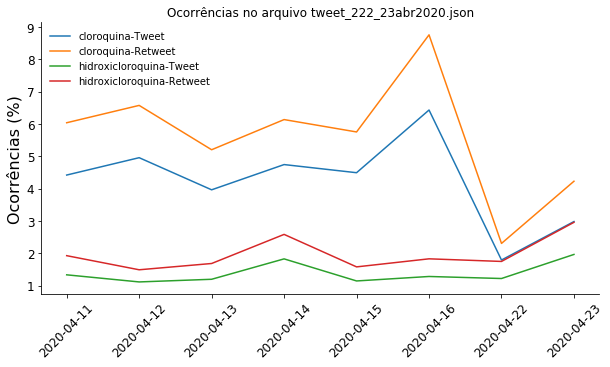

In [112]:
grafico_barras = new.T.plot(kind='line', title ="Ocorrências no arquivo tweet_222_23abr2020.json",figsize=(10,5),legend=True, fontsize=12)
grafico_barras.set_ylabel("Ocorrências (%)",fontsize=16)

plt.xticks(rotation=45)

plt.legend(frameon=False, loc=0)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()


### Gráfico de barras da ocorrência das palavras no tempo decorrido no arquivo

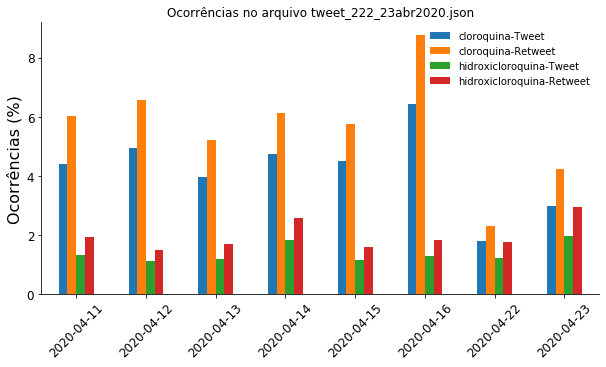

In [113]:
grafico_barras = new.T.plot( kind='bar', title ="Ocorrências no arquivo tweet_222_23abr2020.json",figsize=(10,5),legend=True, fontsize=12)
grafico_barras.set_ylabel("Ocorrências (%)",fontsize=16)

plt.xticks(rotation=45)

plt.legend(frameon=False, loc=0)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()
